In [1]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import applications,activations
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers,utils
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D
from keras.layers import Convolution2D, Activation,MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [2]:
mat = scipy.io.loadmat('wiki_crop/wiki.mat')

In [3]:
# .mat uzantısında olan veri setini pandas kitaplığına çevirdik.

instances = mat['wiki'][0][0][0].shape[1]
 
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]
 
df = pd.DataFrame(index = range(0,instances), columns = columns)
 
for i in mat:
    if i == "wiki":
        current_array = mat[i][0][0]
        
for j in range(len(current_array)):
    df[columns[j]] = pd.DataFrame(current_array[j][0])

In [4]:
df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62328 entries, 0 to 62327
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dob                62328 non-null  int32  
 1   photo_taken        62328 non-null  uint16 
 2   full_path          62328 non-null  object 
 3   gender             59685 non-null  float64
 4   name               62328 non-null  object 
 5   face_location      62328 non-null  object 
 6   face_score         62328 non-null  float64
 7   second_face_score  4096 non-null   float64
dtypes: float64(3), int32(1), object(3), uint16(1)
memory usage: 3.2+ MB


In [6]:
from datetime import datetime, timedelta
def datenum_to_datetime(datenum):
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    exact_date = datetime.fromordinal(int(datenum)) + timedelta(days=int(days)) + timedelta(hours=int(hours)) \
    + timedelta(minutes=int(minutes)) + timedelta(seconds=round(seconds)) - timedelta(days=366)

    return exact_date.year
 
df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)

In [7]:
 # görüntüdeki yaş çıkarımı
df['age'] = df['photo_taken'] - df['date_of_birth']          

In [8]:
df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth,age
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN,1981,28
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248,1925,39
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN,1948,60
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN,1930,31
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN,1971,41


In [9]:
#yüz içermeyen görüntüleri kaldırdık.
df = df[df['face_score'] != -np.inf]
 
#birden fazla yüz içeren görüntüleri kaldırdık.
df = df[df['second_face_score'].isna()]

#üst sınır yaşı 100 yaptık.
df = df[df['age'] <= 100]
 
#doğmamış değerli yaştaki görüntüleri kaldırdık.
df = df[df['age'] > 0]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40157 entries, 0 to 62327
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dob                40157 non-null  int32  
 1   photo_taken        40157 non-null  uint16 
 2   full_path          40157 non-null  object 
 3   gender             39397 non-null  float64
 4   name               40157 non-null  object 
 5   face_location      40157 non-null  object 
 6   face_score         40157 non-null  float64
 7   second_face_score  0 non-null      float64
 8   date_of_birth      40157 non-null  int64  
 9   age                40157 non-null  int64  
dtypes: float64(3), int32(1), int64(2), object(3), uint16(1)
memory usage: 3.0+ MB


In [11]:
# düşük kalitedeki görüntüleri modelde teste kullanılmak için izin verdik.

df = df[df['face_score'] >= 1.75]
 
df = df.drop(columns = ['name','face_score','second_face_score','date_of_birth','face_location'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34200 entries, 0 to 62327
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dob          34200 non-null  int32  
 1   photo_taken  34200 non-null  uint16 
 2   full_path    34200 non-null  object 
 3   gender       33550 non-null  float64
 4   age          34200 non-null  int64  
dtypes: float64(1), int32(1), int64(1), object(1), uint16(1)
memory usage: 1.2+ MB


In [13]:
df.describe()

,dob,photo_taken,gender,age
count,34200.000000,34200.000000,33550.000000,34200.000000
mean,717156.505731,2001.503012,0.740447,38.492661
std,9180.800332,19.586437,0.438396,16.469871
min,677987.000000,1940.000000,0.000000,1.000000
25%,711082.000000,2006.000000,0.000000,26.000000
50%,719659.500000,2010.000000,1.000000,33.000000
75%,724768.250000,2013.000000,1.000000,49.000000
max,734922.000000,2015.000000,1.000000,100.000000


In [14]:
df.head()

,dob,photo_taken,full_path,gender,age
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34


In [15]:
df['path'] = [str(np.squeeze(i)) for i in df['full_path']]
df

,dob,photo_taken,full_path,gender,age,path
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28,17/10000217_1981-05-05_2009.jpg
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60,12/100012_1948-07-03_2008.jpg
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41,16/10002116_1971-05-31_2012.jpg
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52,02/10002702_1960-11-09_2012.jpg
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34,41/10003541_1937-09-27_1971.jpg
...,...,...,...,...,...,...
62321,707521,1968,[38/9996938_1937-02-15_1968.jpg],1.0,31,38/9996938_1937-02-15_1968.jpg
62322,709971,1968,[46/9996946_1943-11-01_1968.jpg],1.0,25,46/9996946_1943-11-01_1968.jpg
62323,707582,1963,[49/9996949_1937-04-17_1963.jpg],1.0,26,49/9996949_1937-04-17_1963.jpg
62325,720620,2013,[09/9998109_1972-12-27_2013.jpg],1.0,41,09/9998109_1972-12-27_2013.jpg


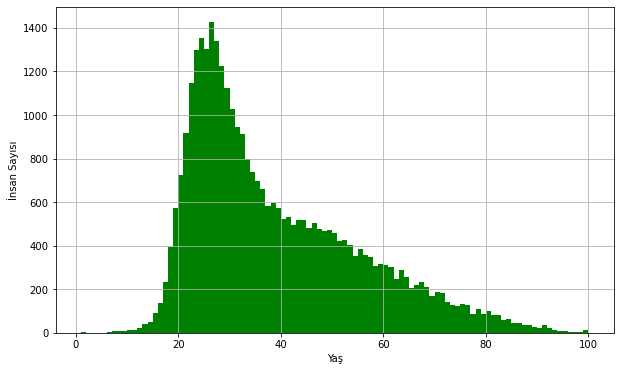

In [16]:
#Veri dağılımını analiz etmek için tablolaştırma yaptık.
#Veri setindeki ağırlık yaş 20-60 yaş arasında olduğu görülmektedir.

df['age'].hist(bins=df['age'].nunique(),color='g',figsize=(10,6))  

plt.xlabel('Yaş')
plt.ylabel('İnsan Sayısı')
plt.show()

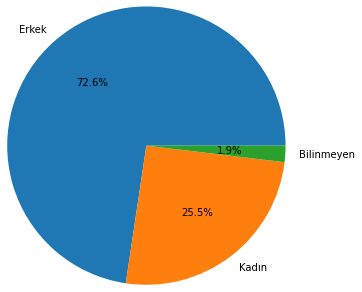

In [17]:
x1 = df[df['gender']==1]['gender'].count()
x2 = df[df['gender']==0]['gender'].count()
inp = [x1,x2,650]
lab = ['Erkek', 'Kadın', 'Bilinmeyen']

plt.pie(inp, labels=lab,radius=1.6,autopct='%.1f%%')
plt.show()


# veri setinde büyük ölçüde erkek bulunmaktadır.

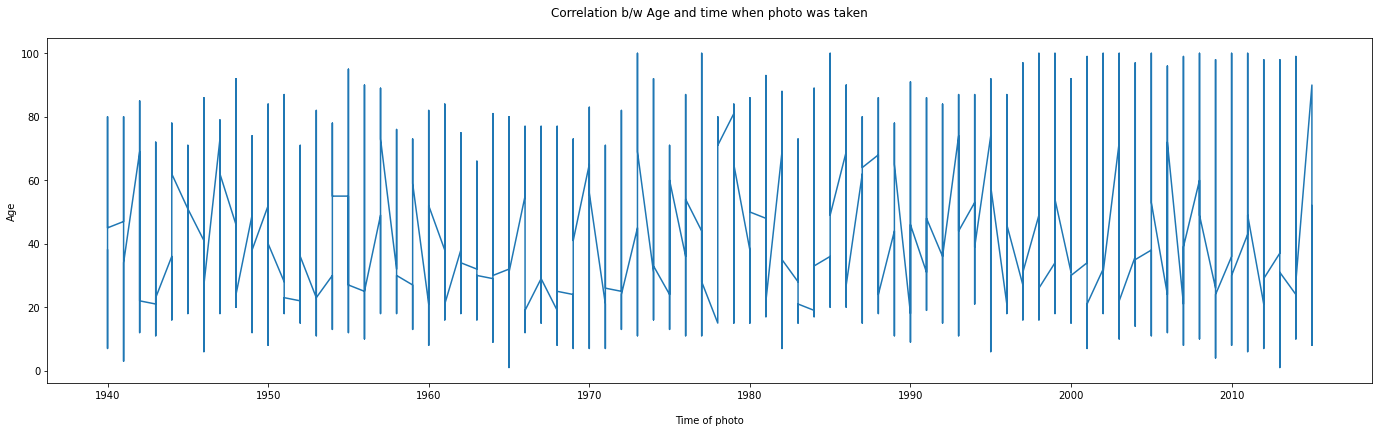

In [18]:
x = df.sort_values(by='photo_taken')

fig= plt.figure(figsize=(23,6))                        
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(x['photo_taken'],x['age'])
plt.title('Correlation b/w Age and time when photo was taken\n')
plt.xlabel('\nTime of photo')
plt.ylabel('Age')
plt.show()

In [19]:
df_copy = df.groupby(['photo_taken'], as_index=False).mean()
df_copy.head()

#ortalama yaş

,photo_taken,dob,gender,age
0,1940,695432.028571,0.751196,36.480952
1,1941,695502.101852,0.750000,37.287037
2,1942,695626.866667,0.848739,37.933333
3,1943,696896.269565,0.745614,35.434783
4,1944,696866.064815,0.859813,36.583333


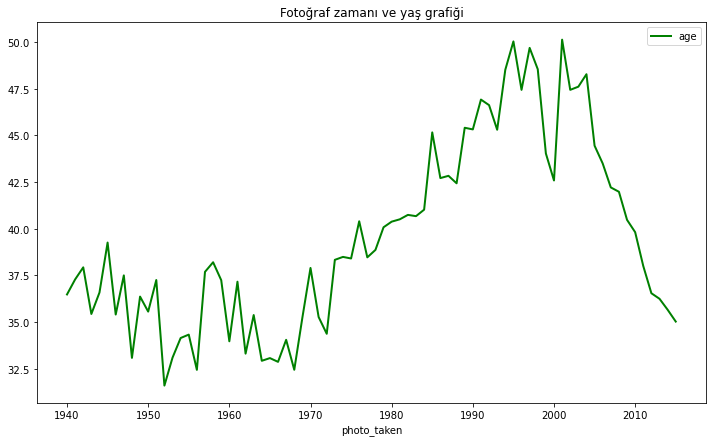

In [20]:
df_copy.plot(x = 'photo_taken', y = 'age', figsize = (12,7), color = 'green', linewidth =2)
plt.title("Fotoğraf zamanı ve yaş grafiği")
plt.xticks(rotation=0)
plt.show()
#1980-2005 yılları arasında yaşlı insanların görüntüleri fazla

In [21]:
# Görüntülerden pixel değerleri çıkarttık.

target_size = (180, 180)
 
def get_image_pixel(image_path):
    pic = load_img("wiki_crop/%s" % image_path[0], color_mode='grayscale', target_size=target_size)
    x = img_to_array(pic).reshape(1, -1)[0]
    return x
 
df['pixels'] = df['full_path'].apply(get_image_pixel)

In [22]:
df.head()

,dob,photo_taken,full_path,gender,age,path,pixels
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28,17/10000217_1981-05-05_2009.jpg,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60,12/100012_1948-07-03_2008.jpg,"[95.0, 92.0, 96.0, 96.0, 99.0, 98.0, 93.0, 93...."
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41,16/10002116_1971-05-31_2012.jpg,"[37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37...."
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52,02/10002702_1960-11-09_2012.jpg,"[121.0, 121.0, 121.0, 122.0, 122.0, 123.0, 123..."
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34,41/10003541_1937-09-27_1971.jpg,"[190.0, 204.0, 203.0, 201.0, 204.0, 200.0, 201..."


In [23]:
x = df['age']           
x = x.sort_values()
x.unique()

array([  1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

In [24]:
df['pixels'][0].size

32400

In [25]:
#ortalama pixel değerleri çıkartıldı.

x = df.sort_values(by='age')
x.reset_index(inplace=True)

x['pixel_per_image'] = x['pixels']
x['pixel_deviation_per_image'] = x['pixels']

#for i in range(34200):
 #x['pixel_per_image'][i] = x['pixels'][i].mean()
 #x['pixel_deviation_per_image'][i] = x['pixels'][i].max()-x['pixels'][i].min()

x.head()

,index,dob,photo_taken,full_path,gender,age,path,pixels,pixel_per_image,pixel_deviation_per_image
0,53357,734922,2013,[27/34853027_2012-02-23_2013.jpg],0.0,1,27/34853027_2012-02-23_2013.jpg,"[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200...","[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200...","[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200..."
1,5669,717349,1965,[33/6802033_1964-01-13_1965.jpg],1.0,1,33/6802033_1964-01-13_1965.jpg,"[196.0, 196.0, 196.0, 196.0, 196.0, 196.0, 196...","[196.0, 196.0, 196.0, 196.0, 196.0, 196.0, 196...","[196.0, 196.0, 196.0, 196.0, 196.0, 196.0, 196..."
2,41240,707981,1941,[57/35652957_1938-05-21_1941.jpg],1.0,3,57/35652957_1938-05-21_1941.jpg,"[219.0, 181.0, 195.0, 212.0, 180.0, 168.0, 182...","[219.0, 181.0, 195.0, 212.0, 180.0, 168.0, 182...","[219.0, 181.0, 195.0, 212.0, 180.0, 168.0, 182..."
3,42685,732518,2009,[81/37696581_2005-07-25_2009.jpg],1.0,4,81/37696581_2005-07-25_2009.jpg,"[201.0, 201.0, 201.0, 201.0, 201.0, 201.0, 201...","[201.0, 201.0, 201.0, 201.0, 201.0, 201.0, 201...","[201.0, 201.0, 201.0, 201.0, 201.0, 201.0, 201..."
4,53303,731956,2009,[76/24896876_2004-01-10_2009.jpg],0.0,5,76/24896876_2004-01-10_2009.jpg,"[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....","[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....","[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14...."


In [26]:
from sklearn.utils import shuffle
df = shuffle(df)
train = df[:28500]
val = df[28500:]

In [27]:
from keras_preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255.,                
                           rotation_range=25,
                           brightness_range=[0.7,1.3],
                           zoom_range=0.5,
                           horizontal_flip=True)    

valid_datagen=ImageDataGenerator(rescale=1./255.)                
                           

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory='wiki_crop',
    x_col="path",
    y_col="age",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(180,180))

valid_generator=valid_datagen.flow_from_dataframe(
    dataframe=val,
    directory="wiki_crop",
    x_col="path",
    y_col="age",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(180,180))

Found 28500 validated image filenames.
Found 5700 validated image filenames.


In [28]:
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import SpatialDropout2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.regularizers import l1_l2

input_shape = (180, 180, 3)
inputs = Input(shape=input_shape)

x = SeparableConv2D(64, (3, 3), padding="same")(inputs)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = SeparableConv2D(128, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = SeparableConv2D(128, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.15)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(256, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.15)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(256, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.15)(x)
x = BatchNormalization()(x)

x = Flatten()(x)

x = Dense(128)(x)
x = Activation("relu")(x)
x = Dropout(0.30)(x)
x = BatchNormalization()(x)

x = Dense(64)(x)
x = Activation("relu")(x)
x = Dropout(0.30)(x)
x = BatchNormalization()(x)

x = Dense(64)(x)
x = Activation("relu")(x)
x = Dropout(0.20)(x)
x = BatchNormalization()(x)

x = Dense(1)(x)
x = Activation("relu")(x)           

age_model = Model(inputs=inputs, outputs=x)

In [29]:
age_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 separable_conv2d (Separable  (None, 180, 180, 64)     283       
 Conv2D)                                                         
                                                                 
 activation (Activation)     (None, 180, 180, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 64)       256       
 ormalization)                                                   
                                                             

In [36]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.008
	drop = 0.7
	epochs_drop = 12.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adam(lr=0.0)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

age_model.compile(loss='mse', optimizer=opt, metrics=['mae','mse'])

STEP_SIZE_TRAIN=460
STEP_SIZE_VALID=460

Model = Sequential()

history = age_model.fit_generator(generator=train_generator,steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator,
                     validation_steps=STEP_SIZE_VALID, callbacks=callbacks_list, epochs=35)

C:\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-36-e233e4654ce5>:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = age_model.fit_generator(generator=train_generator,steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator,


Epoch 1/35
460/460 [==============================] - 1574s 3s/step - loss: 252.2671 - mae: 12.7641 - mse: 252.2671 - val_loss: 234.5343 - val_mae: 11.6977 - val_mse: 234.5343 - lr: 0.0080


In [37]:
age_model.save('my_age_model')
age_model.save('my_age_model.h5')

INFO:tensorflow:Assets written to: my_age_model\assets


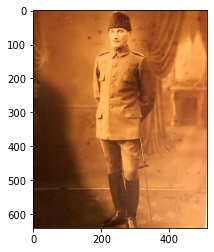

[[32.41648]]


In [44]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

 # girdi aynı dosya içinde olmalıdır.
picture = "1914_sofya.jpg"                                  
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()

prediction = age_model.predict(loadImage(picture))
print(prediction)


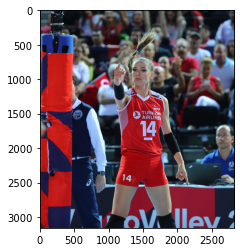

[[32.70012]]


In [39]:
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "eda.jpg"                                  
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()

prediction = age_model.predict(loadImage(picture))
print(prediction)


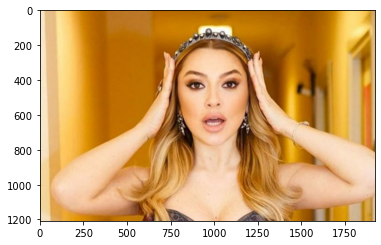

[[29.655708]]


In [46]:
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "hadise.jpg"                                  
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()

prediction = age_model.predict(loadImage(picture))
print(prediction)


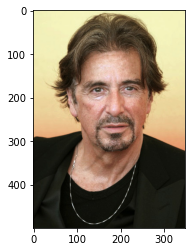

[[47.04734]]


In [47]:
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "Al_Pacino.jpg"                                  
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()

prediction = age_model.predict(loadImage(picture))
print(prediction)
